In [ ]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# In this python script is implemented the 0D model of a MSFR with the following characteristcs.

P0      = 3000e6                    # W thermal                                              [W]
Tf_out0 = 1050                      # Fuel outlet core temperature in Steady state           [°K]
Tf_in0  = 950                       # Fuel inlet core temperature in Steady state            [°K]
Tf0     = 1000                      # Fuel average temperature in Steady state               [°K]
H_core  = 2.65                      # Height of the core                                     [m]
Dh_core = 2.1                       # Hydraulic diameter of the core                         [m]
A_core  = np.pi*(Dh_core/2)**2      # Area of the core                                       [m^2]
H_ihx   = 2.4                       # Height of the Heat exchanger                           [m]
A_ihx   = 2.24                      # Area of the Heat exchanger                             [m^2]
D_ihx   = np.sqrt(4*A_ihx/np.pi)    # Hydraulic diameter of the external circuit             [m]
L_hl    = 2                         # Length of the hot leg                                  [m]
L_cl    = 2                         # Length of the cold leg                                 [m]
Gf0     = 18000                     # Fuel mass flow rate in Steady state                    [Kg/s]
mhl     = 5760                      # Mass of coolant in the hot leg                         [Kg]
mcl     = 5760                      # Mass of coolant in the cold leg                        [Kg]
V_core  = A_core*H_core             # Volume of the core                                     [m^3]
V_ihx   = A_ihx*H_ihx               # Volume of the Heat exchanger                           [m^3]


def dens_f(Tf):
    return 4983.56 - 0.882 * Tf                # Density of the fuel in the core

def dens_1(T1):
    return 4983.56 - 0.882 * T1                # Density of the fuel in the heat exchanger

def cp_f(Tf):
    return -1111 + 2.78 * Tf                   # Specific heat capacity in the core

def cp_1(T1):
    return -1111 + 2.78 * T1                   # Specific heat capacity in the heat exchanger

def mf(Tf):
    return dens_f(Tf)*V_core                   # Mass in the core

def m1(T1):
    return dens_1(T1)*V_ihx                    # Mass in the heat exchanger



# Calculation parameters primary side
T1_in0  = Tf_out0                                                                  # Heat exchanger inlet temperature in Steady state                   [°K]
T1_out0 = Tf_in0                                                                   # Fuel inlet temperature in Steady state                             [°K]
T1_0    = (T1_in0 + T1_out0)/2                                                     # Initial heat exchanger temperature in Steady state                 [°K]
mf0     = mf(Tf0)                                                                  # Total core fuel mass [kg] (If I have freeze for a second the reactor I know the mass present is that one)
m10     = m1(T1_0)                                                                 # IHX primary coolant mass [kg] (If I have freeze for a second the reactor I know that in the HX I have that mass present)
cf0     = cp_f(Tf0)                                                                # Fuel specifc heat capacity in the core                             [J/(kg*K)]
cc0     = cp_1(T1_0)                                                               # Fuel specifc heat capacity in the heat exchanger                   [J/(kg*K)]


# Steady state values of velocity in the circuit

v_core0 = Gf0/(dens_f(Tf0)*A_core)                                                 # Reference velocity of fluid in the core
v_hl0   = Gf0/(dens_f(Tf_out0)*A_ihx)                                              # Reference velocity of the fluid in the hot leg
v_ihx0  = Gf0/(dens_1((Tf_in0 + Tf_out0)/2)*A_ihx)                                 # Reference velocity of the fluid in the Heat exchanger
v_cl0   = Gf0/(dens_1(Tf_in0)*A_ihx)                                               # Reference velocity of the fluid in the cold leg


tau_c0  = H_core/v_core0                                                           # Time in the core               [s]
t_hl0   = L_hl/v_hl0                                                               # Time in the hot leg            [s]
t_cl0   = L_cl/v_cl0                                                               # Time in the cold leg           [s]
t_ihx0  = H_ihx/v_ihx0                                                             # Time in the heat exchanger     [s]

tau_ec0  = t_hl0 + t_cl0 + t_ihx0                                                  # Time in the external loop      [s]

tau_hl0 = 0.32                                                                     # Primary hot leg time constant  [s]
tau_cl0 = 0.32                                                                     # Primary cold leg time constant [s]


# Neutronics
lam = np.array([1.33104e-2, 3.05427e-2, 1.15179e-1, 3.01152e-1, 8.79376e-1, 2.91303])
bi  = np.array([8.42817e-5, 6.84616e-4, 4.79796e-4, 1.03883e-3, 5.49185e-4, 1.84087e-4])


precursor_time = np.log(2)*lam**-1                                                 # Precursor time formula

b = np.sum(bi)                                                                     # Total beta fraction
biglambd = 3.46402e-7                                                              # Mean neutron generation lifetime [s]

# Reactivity feedbacks
alpha_f = -4.665e-5                                                                # [NOTpcm/K]
#alpha_f = -5.87554e-5                                                             # [NOTpcm/K]


# Secondary Side
# Geometry of the Secondary loop + Energy conversion loop

A_sec   = 3.6                                                                      # Area of the secondary side Heat exchanger            [m2]
H_sec   = 2.4                                                                      # Height of the secondary side Heat exchanger          [m]
V_sec   = A_sec*H_sec                                                              # Volume of the secondary side Heat exchanger          [m3]

A_sg    = 2.4                                                                      # Area of the Steam generator where water flows in     [m2]
H_sg    = 3.2                                                                      # Height of the Steam generator where water flows in   [m]
V_sg    = A_sg*H_sg                                                                # Volume of the Steam generator where water flows in   [m3]

H_He    = 3.2                                                                      # Height of the heat exchanger where Helium flows in   [m3]
A_He    = 7.2                                                                      # Area of the heat exchanger where Helium flows in     [m2]
V_He    = A_He*H_He                                                                # Volume of the heat exchanger where Helium flows in   [m3]


G2_0      = 16990                                                                  # Mass flow rate of the secondary salt in SS           [kg/s]
cp_2      = 2390                                                                   # Specific heat of the secondary salt                  [J/Kg*K]
T2_in0    = 860.15                                                                 # Inlet temperature of the secondary salt              [K]
T2_out0   = 934.15                                                                 # Outlet temperature of the secondary salt             [K]
T2_0      = (T2_out0 + T2_in0)/2                                                   # Average temperature of the secondary salt            [K]
Tsg_in0   = T2_out0                                                                # Inlet temperature of the Steam generator             [K]
Tsg_out0  = T2_in0                                                                 # Outlet temperature of the Steam generator            [K]
Tsg_0     = (Tsg_out0 + Tsg_in0)/2                                                 # Average temperature of the Steam generator           [K]


tau_hl2  = 0.32                                                                    # Secondary hot leg time constant                      [s]
tau_cl2  = 0.32                                                                    # Secondary cold leg time constant                     [s]


Tw_in0   = 673.15                                                                  # Inlet temperature in the Steam generator             [K]
Tw_out0  = 897.65                                                                  # Outlet temperature in the Steam generator            [K]
Tw_0     = (Tw_out0 + Tw_in0)/2                                                    # Average temperature in the Steam generator           [K]

dens_He  = 5.36
mw       = dens_He*7.2*3.2                                                         # Water mass in the Steam generator                    [Kg]
cp_w     = 5193                                                                    # Specific heat of the water in the Steam generator    [J/Kg*K]
Gw_0     = 2580                                                                     # Mass flow rate of water in the Steam generator in SS [Kg/s]


K       = - Gf0*cc0*(T1_out0 - T1_in0)/(T1_0 - T2_0)                               # Heat exchanger coefficient
K_sg    = - G2_0*cp_2*(Tsg_out0 - Tsg_in0)/(Tsg_0 - Tw_0)                          # Heat exchanger coefficient in the Steam generator


def dens_2(T2):
    return 2146.3 - 0.4884 * T2                                                    # Density of the Salt in the intermediate heat exchanger

def dens_sg(Tsg):
    return 2146.3 - 0.4884 * Tsg                                                   # Density of the Salt in the Steam generator

def m2(T2):
    return dens_2(T2)*V_sec                                                        # Mass in the intermediate Heat exchanger

def m_sg(Tsg):
    return dens_sg(Tsg)*V_sg                                                       # Mass in the Steam generator


m2_0    = m2(T2_0)                                                                 # Total IHX salt mass [kg]
m_sg0   = m_sg(Tsg_0)                                                              # SG coolant mass [kg]



v_sec   = G2_0/(dens_2(T2_0)*A_sec)                                                # Reference velocity of the Salt in the IHX
v_sg    = G2_0/(dens_sg(Tsg_0)*A_sg)                                               # Reference velocity of the Salt in the Steam generator
v_w     = Gw_0/(dens_He*A_sg)                                                      # Reference velocity of the water in the Steam generator


tau_f    = (Gf0/cp_f(Tf0))**-1                                                     # Fuel time constant  [s]
tau_IHX1 = (K/(m10*cc0))**-1                                                       # Time constant of the primary salt in IHX [s]
tau_IHX2 = (K/(m2_0*cp_2))**-1                                                     # Time constant of the secondary salt in IHX [s]
tau_SG2  = (K_sg/(m_sg0*cp_2))**-1                                                 # Time constant of the secondary salt in SG [s]


#Initial conditions
C1_0 = bi[0]*P0 / (biglambd*(lam[0] + 1/tau_c0 - np.exp(-lam[0]*tau_ec0)/tau_c0))
C2_0 = bi[1]*P0 / (biglambd*(lam[1] + 1/tau_c0 - np.exp(-lam[1]*tau_ec0)/tau_c0))
C3_0 = bi[2]*P0 / (biglambd*(lam[2] + 1/tau_c0 - np.exp(-lam[2]*tau_ec0)/tau_c0))
C4_0 = bi[3]*P0 / (biglambd*(lam[3] + 1/tau_c0 - np.exp(-lam[3]*tau_ec0)/tau_c0))
C5_0 = bi[4]*P0 / (biglambd*(lam[4] + 1/tau_c0 - np.exp(-lam[4]*tau_ec0)/tau_c0))
C6_0 = bi[5]*P0 / (biglambd*(lam[5] + 1/tau_c0 - np.exp(-lam[5]*tau_ec0)/tau_c0))


TH_0 = np.array([Tf0, T1_in0, T1_0, Tf_in0, T2_0, Tsg_in0, Tsg_0, T2_in0, Tw_0])   # Initial temperature conditions
NEU_0 = np.array([P0, C1_0, C2_0, C3_0, C4_0, C5_0, C6_0])                         # Initial neutronics conditions
MSFR_0 = np.append(NEU_0, TH_0)                                                    # Initial neutronics + thermal hydraulics conditions

# Calculate rho_0
rho_eq = b - np.sum((bi * lam) / (lam + (1 - np.exp(-lam * tau_ec0)) / tau_c0))    # Equilibrium reactivity

print(f"The reactivity needed for criticality is: {rho_eq*10**5} [pcm]")
print(f"The total beta is: {b*10**5} [pcm]")
print(f"t_C1: {precursor_time[0]} [s]")
print(f"t_C2: {precursor_time[1]} [s]")
print(f"t_C3: {precursor_time[2]} [s]")
print(f"t_C4: {precursor_time[3]} [s]")
print(f"t_C5: {precursor_time[4]} [s]")
print(f"t_C6: {precursor_time[5]} [s]")
print(f"Precursor 1 initial: {C1_0}")
print(f"Precursor 2 initial: {C2_0}")
print(f"Precursor 3 initial: {C3_0}")
print(f"Precursor 4 initial: {C4_0}")
print(f"Precursor 5 initial: {C5_0}")
print(f"Precursor 6 initial: {C6_0}")
print("-----------------------------------------------------------------------------")
print(f"Reference velocity in the core is : {v_core0} [m/s]")
print(f"Reference velocity in the hot leg is : {v_hl0} [m/s]")
print(f"Reference velocity in the heat exchanger is : {v_ihx0} [m/s]")
print(f"Reference velocity in the cold leg is : {v_cl0} [m/s]")
print(f"Time spent in the core is: {tau_c0} [s]")
print(f"Time spent in the outside the loop is: {tau_ec0} [s]")
print(f"Steady state core mass is: {mf0} [Kg]")
print(f"Steady state heat exchanger mass: {m10} [s]")
print(f"Steady state mass flow rate : {Gf0} [Kg/s]")
print(f"Steady state fuel specific heat in the core: {cf0} [J/KgK]")
print(f"Steady state fuel specific heat in the heat exchanger: {cc0} [J/KgK]")
print("-----------------------------------------------------------------------------")
print(f"Time fuel constant is: {tau_f} [s]")
print(f"Time fuel constant is: {tau_f} [s]")
print(f"Time fuel constant is: {tau_f} [s]")
print(f"Time fuel constant is: {tau_f} [s]")
print("-----------------------------------------------------------------------------")
print(f"Reference velocity of the coolant salt in the Secondary side is : {v_sec} [m/s]")
print(f"Reference velocity of the coolant salt in the Steam generator is : {v_sg} [m/s]")
print(f"Reference velocity of water in the Steam generator is : {v_w} [m/s]")
print(f"Steady state coolant Salt mass in Intermediate heat exchanger is: {m2_0} [Kg]")
print(f"Steady state coolant Salt mass in the Steam generator is: {m_sg0} [Kg]")
print(f"Steady state coolant Mass of water in the Steam generator is: {mw} [Kg]")
print(f"Steady state coolant Salt flow rate in Intermediate heat exchanger is : {G2_0} [Kg/s]")
print(f"Steady state coolant Salt specific heat in heat exchanger: {cp_2} [J/Kg*K]")





The reactivity needed for criticality is: 146.15931290161498 [pcm]
The total beta is: 302.07957 [pcm]
t_C1: 52.075608588768574 [s]
t_C2: 22.69436495659995 [s]
t_C3: 6.017999640211716 [s]
t_C4: 2.301652257198841 [s]
t_C5: 0.7882261746510539 [s]
t_C6: 0.23794714800738245 [s]
Precursor 1 initial: 21688611077138.766
Precursor 2 initial: 78071035849866.31
Precursor 3 initial: 15673851693726.863
Precursor 4 initial: 14981824252274.414
Precursor 5 initial: 3574819848409.6484
Precursor 6 initial: 470131961911.37177
-----------------------------------------------------------------------------
Reference velocity in the core is : 1.2670535359618895 [m/s]
Reference velocity in the hot leg is : 1.9804789907267808 [m/s]
Reference velocity in the heat exchanger is : 1.9591848676392116 [m/s]
Reference velocity in the cold leg is : 1.9383437825857122 [m/s]
Time spent in the core is: 2.0914664809235863 [s]
Time spent in the outside the loop is: 3.266664675555556 [s]
Steady state core mass is: 37646.3966

In [ ]:
#LOSS OF FLOW ACCIDENT transient equations

# Variation of the flow rate
Gfinal = 2100


def Gf(t):
    return Gfinal + (Gf0 - Gfinal) / (1 + np.exp(0.5*(t-60)))    # Core mass flow rate

def Gf_ihx(t):
    return Gfinal + (Gf0 - Gfinal) / (1 + np.exp(0.5*(t-60)))    # Flow rate in the intermediate heat exchanger



def Gf(t):
    return Gf0 + t*0

def Gf_ihx(t):
    return Gf0 + t*0


# Time constants

def tau_c(Tf, t):
    return (H_core*A_core*dens_f(Tf))/Gf(t)

def tau_hl(T1_in, t):
    return (L_hl*A_ihx*dens_f(T1_in))/Gf(t)

def tau_cl(Tf_in, t):
    return (L_cl*A_ihx*dens_1(Tf_in))/Gf_ihx(t)

def tau_ihx(T1, t):
    return (H_ihx*A_ihx*dens_1(T1))/Gf_ihx(t)

def tau_ec(tau_hl, tau_cl ,tau_ihx):
    return tau_hl + tau_cl + tau_ihx

def hotleg_time(t):                                             # Hot leg time constant
    return mhl/Gf_ihx(t)

def coldleg_time(t):                                            # Cold leg time constant
    return mcl/Gf_ihx(t)


# Reactivity insertions

def sin_reactivity(t,omega):
    return np.sin(omega*t)*1e-5

def ramp_reactivity(t,gamma):
    return gamma*t*1e-5

def rho_control_rod(dh):
    return 10e-5*dh


In [ ]:
# Define time span and evaluation points
t_0 = 0                                                                          # In seconds
t_f = 50                                                                         # End seconds
t_span = (t_0, t_f)                                                              # Time interval
t = np.linspace(t_0, t_f, 1000000)                                               # Points at which to store the solution

#Inputs for reactivity
omega = 0                                                                        # Reactivity ramp coefficient
gamma = 0                                                                        # Reactivity frequency coefficient
dh    = 10                                                                       # Differential height of the rod in [cm]
rho_eq = 146.15931290161498*1e-5

def Dyn_model(t, state):
    # Unpack state variables
    P, C1, C2, C3, C4, C5, C6, Tf, T1_in, T1, Tf_in, T2, Tsg_in, Tsg, T2_in, Tw = state

    # Power equation
    dPdt = P*(rho_eq + rho_control_rod(dh) + ramp_reactivity(t,gamma) + sin_reactivity(t,omega) + alpha_f*(Tf-TH_0[0]) - b)/biglambd + lam[0]*C1 + lam[1]*C2 + lam[2]*C3 + lam[3]*C4 + lam[4]*C5 + lam[5]*C6  # Power equation

    # Precursor equations
    dC1dt = bi[0]*P/biglambd - lam[0]*C1 - C1 / tau_c(Tf, t) + (1 / tau_c(Tf, t)) * C1 * np.exp(-lam[0] * tau_ec(tau_hl(T1_in, t), tau_cl(Tf_in, t) ,tau_ihx(T1, t)))          # Precursor 1 equation
    dC2dt = bi[1]*P/biglambd - lam[1]*C2 - C2 / tau_c(Tf, t) + (1 / tau_c(Tf, t)) * C2 * np.exp(-lam[1] * tau_ec(tau_hl(T1_in, t), tau_cl(Tf_in, t) ,tau_ihx(T1, t)))          # Precursor 2 equation
    dC3dt = bi[2]*P/biglambd - lam[2]*C3 - C3 / tau_c(Tf, t) + (1 / tau_c(Tf, t)) * C3 * np.exp(-lam[2] * tau_ec(tau_hl(T1_in, t), tau_cl(Tf_in, t) ,tau_ihx(T1, t)))          # Precursor 3 equation
    dC4dt = bi[3]*P/biglambd - lam[3]*C4 - C4 / tau_c(Tf, t) + (1 / tau_c(Tf, t)) * C4 * np.exp(-lam[3] * tau_ec(tau_hl(T1_in, t), tau_cl(Tf_in, t) ,tau_ihx(T1, t)))          # Precursor 4 equation
    dC5dt = bi[4]*P/biglambd - lam[4]*C5 - C5 / tau_c(Tf, t) + (1 / tau_c(Tf, t)) * C5 * np.exp(-lam[4] * tau_ec(tau_hl(T1_in, t), tau_cl(Tf_in, t) ,tau_ihx(T1, t)))          # Precursor 5 equation
    dC6dt = bi[5]*P/biglambd - lam[5]*C6 - C6 / tau_c(Tf, t) + (1 / tau_c(Tf, t)) * C6 * np.exp(-lam[5] * tau_ec(tau_hl(T1_in, t), tau_cl(Tf_in, t) ,tau_ihx(T1, t)))          # Precursor 6 equation


    dTfdt    = P / (mf0 * cp_f(Tf)) - 2 * Gf(t) * (Tf - Tf_in) / mf0                       # Core differential equation

    dT1_indt = (2 * Tf - Tf_in - T1_in) / hotleg_time(t)                                   # Hot leg differential equation

    dT1dt    =  - K * (T1 - T2) / (m10 * cp_1(T1_0)) - 2 * Gf_ihx(t) * (T1 - T1_in) / m10  # Intermediate heat exchanger equation

    #dT1dt   =  - K * (2*T1-2*T1_in)/np.log((2*T1-T1-T2)/(T1_in - T2)) / (m10 * cp_1(T1_0)) - 2 * Gf_ihx(t) * (T1 - T1_in) / m10

    dTf_indt = (2 * T1 - T1_in - Tf_in) / coldleg_time(t)                                  # Cold leg differential equation

    ####################### Secondary Side ##############################

    dT2dt    = K * (T1-T2)/(m2(T2_0)*cp_2) - 2*G2_0*(T2  - T2_in)/m2(T2_0)                 # Secondary salt in IHX differential equation

    dTsg_in  = (2 * T2 - T2_in - Tsg_in) / tau_hl2                                         # Hot leg differential equation

    dTsgdt   = - K_sg*(Tsg - Tw)/(m_sg(Tsg_0) * cp_2) - 2*G2_0*(Tsg - Tsg_in)/m_sg(Tsg_0)  # Intermediate heat exchanger equation

    dT2_indt =   (2*Tsg - Tsg_in - T2_in) / tau_cl2                                        # Cold leg differential equation

    dTwdt    =   K_sg*(Tsg - Tw)/(mw*cp_w) - 2*Gw_0*(Tw - Tw_in0)/mw                       # Water differential equation

    #####################################################################

    # Pack the derivatives into a single vector
    dXdt = [dPdt, dC1dt, dC2dt, dC3dt, dC4dt, dC5dt, dC6dt, dTfdt, dT1_indt, dT1dt, dTf_indt, dT2dt, dTsg_in, dTsgdt, dT2_indt, dTwdt]

    return dXdt

# Solve ODEs
#sol = sp.integrate.solve_ivp(fun=Dyn_model, t_span, y0, t_eval = t, method = 'LSODA', rtol = 1e-10, atol = 1e-12)
sol = sp.integrate.solve_ivp(
    fun=Dyn_model,             # Function that defines the system of ODEs
    t_span=t_span,             # Time interval for the solution
    y0=MSFR_0,                 # Initial condition (using 'y0' correctly)
    t_eval=t,                  # Times at which to evaluate the solution
    method='LSODA',            # Numerical integration method
    rtol=1e-12,                # Relative tolerance
    atol=1e-12                 # Absolute tolerance
)


# Post-process and plot

normalized_power = sol.y[0] / (P0)                                                                                                           # Normalized power to MW
delta_Tf = sol.y[7] - TH_0[0]                                                                                                                # Fuel temperature variation
rho = (rho_eq  + rho_control_rod(dh) + ramp_reactivity(t,gamma) + sin_reactivity(t,omega) + alpha_f*delta_Tf)*1e5                            # Reactivity in pcm



In [ ]:
# If the system reaches a new Steady state after a perturbation of some kind to system is correct if Tf = T1 , and that T2 = Tsg
# Beacuse it is an imposed power system there is a change in temperature when considering a new steady state

print(f"The Initial steady state temperature Tf is: {sol.y[7][0]-273.15} [°C]")
print(f"The Initial steady state temperature T1 in IHX: {sol.y[9][0]-273.15} [°C]")
print(f"The Initial steady state temperature T2 in IHX: {sol.y[11][0]-273.15} [°C]")
print(f"The Initial steady state temperature Tsg in SG: {sol.y[13][0]-273.15} [°C]")
print(f"The Initial steady state temperature Tw in SG: {sol.y[15][0]-273.15} [°C]")
print("-----------------------------------------------------------------------------")
Tf_out = 2*sol.y[7] - sol.y[10]
print(f"The final steady state Outlet temperature Tf_out is: {Tf_out[-1]-273.15} [°C]")
print(f"The final steady state Inlet temperature Tf_in is: {sol.y[10][-1]-273.15} [°C]")
print(f"The final steady state temperature Tf is: {sol.y[7][-1]-273.15} [°C]")
print("-----------------------------------------------------------------------------")
print(f"The final steady state temperature T1_in is: {sol.y[8][-1]-273.15} [°C]")
print(f"The final steady state temperature T1 in IHX: {sol.y[9][-1]-273.15} [°C]")
print("-----------------------------------------------------------------------------")
print(f"The final steady state temperature T2_in in IHX: {sol.y[14][-1]-273.15} [°C]")
print(f"The final steady state temperature T2 in IHX: {sol.y[11][-1]-273.15} [°C]")
print("-----------------------------------------------------------------------------")
print(f"The final steady state temperature Tsg_in in IHX: {sol.y[14][-1]-273.15} [°C]")
print(f"The final steady state temperature Tsg in SG: {sol.y[13][-1]-273.15} [°C]")
print(f"The final steady state temperature Tw in SG: {sol.y[15][-1]-273.15} [°C]")
print("-----------------------------------------------------------------------------")

power_reactivity = (b - biglambd * (sum(lam[i] * sol.y[i + 1] for i in range(6))) / sol.y[0]) * 1e5


The Initial steady state temperature Tf is: 726.85 [°C]
The Initial steady state temperature T1 in IHX: 726.85 [°C]
The Initial steady state temperature T2 in IHX: 624.0 [°C]
The Initial steady state temperature Tsg in SG: 624.0 [°C]
The Initial steady state temperature Tw in SG: 512.25 [°C]
-----------------------------------------------------------------------------
The final steady state Outlet temperature Tf_out is: 801.5517681915272 [°C]
The final steady state Inlet temperature Tf_in is: 694.9506139323937 [°C]
The final steady state temperature Tf is: 748.2511910619605 [°C]
-----------------------------------------------------------------------------
The final steady state temperature T1_in is: 801.5516404423194 [°C]
The final steady state temperature T1 in IHX: 748.2511813664115 [°C]
-----------------------------------------------------------------------------
The final steady state temperature T2_in in IHX: 599.1790964787959 [°C]
The final steady state temperature T2 in IHX: 638

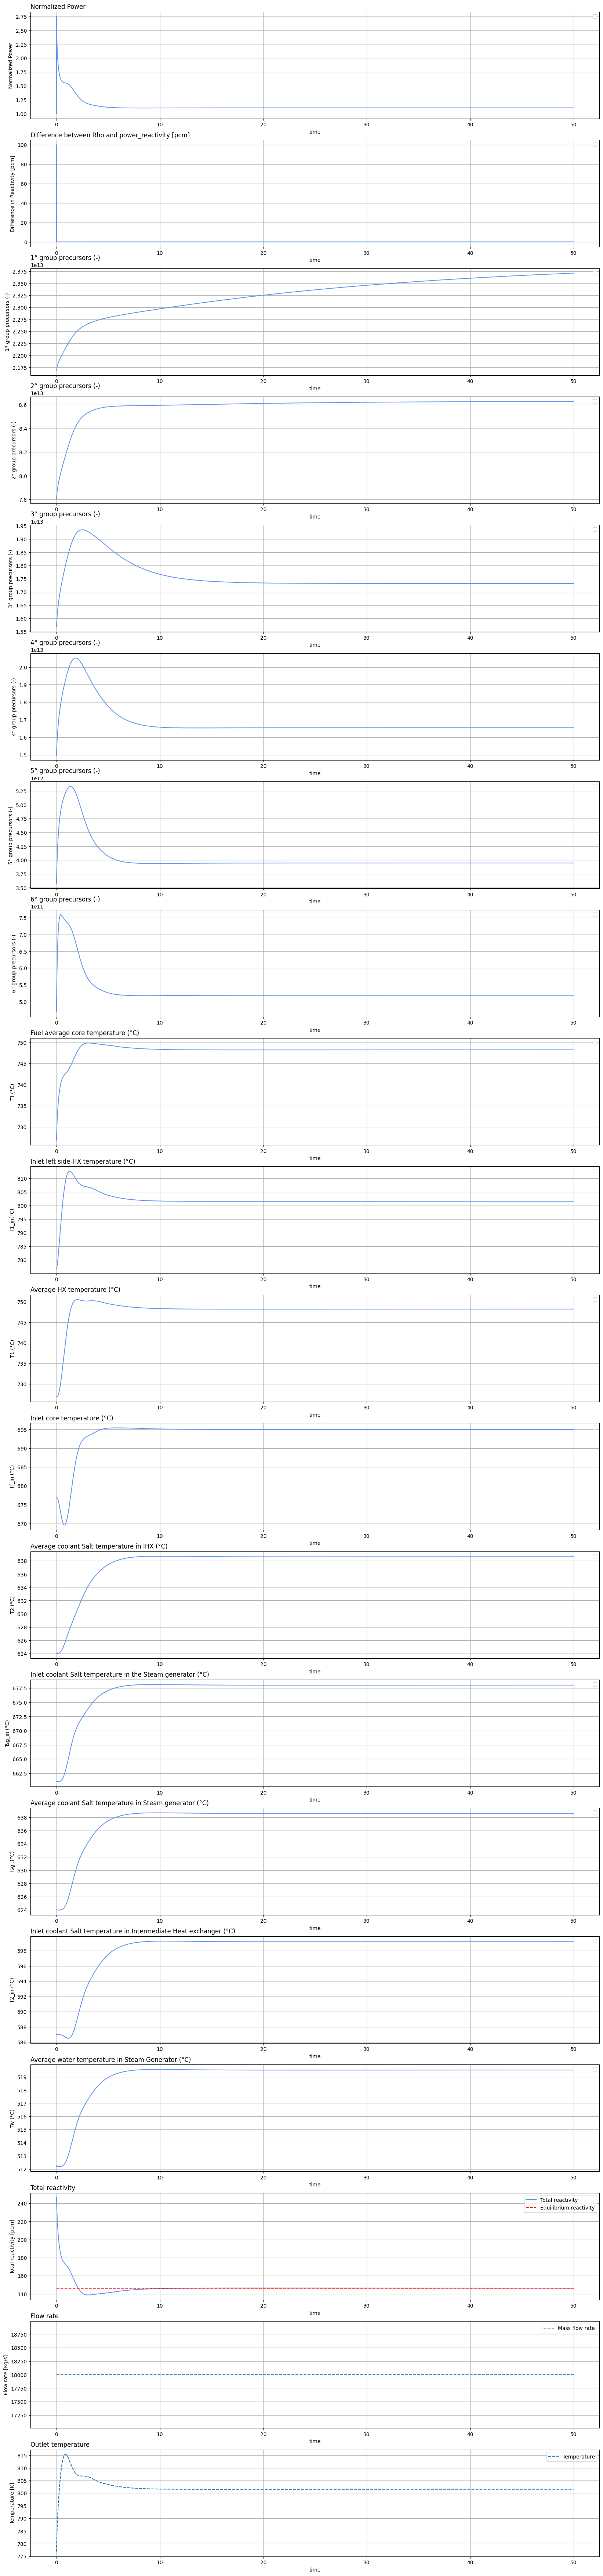

In [ ]:
fig, axs = plt.subplots(len(sol.y)+4, 1, figsize=(20, 90))

# Define a darker blue color
darker_blue = "#6495ED"

axs[0].plot(t, normalized_power, color=darker_blue)
axs[0].set_title("Normalized Power", loc='left')
axs[0].set_xlabel("time")
axs[0].set_ylabel("Normalized Power")
axs[0].legend()
axs[0].grid(True)

# Expressing reactivity t
axs[1].plot(t, rho - power_reactivity, color=darker_blue)
axs[1].set_title("Difference between Rho and power_reactivity [pcm]", loc='left')
axs[1].set_xlabel("time")
axs[1].set_ylabel("Difference in Reactivity [pcm]")
axs[1].legend()
axs[1].grid(True)

axs[2].plot(t, sol.y[1], color=darker_blue)
axs[2].set_title("1° group precursors (-)", loc='left')
axs[2].set_xlabel("time")
axs[2].set_ylabel("1° group precursors (-)")
axs[2].legend()
axs[2].grid(True)

axs[3].plot(t, sol.y[2], color=darker_blue)
axs[3].set_title("2° group precursors (-)", loc='left')
axs[3].set_xlabel("time")
axs[3].set_ylabel("2° group precursors (-)")
axs[3].legend()
axs[3].grid(True)

axs[4].plot(t, sol.y[3], color=darker_blue)
axs[4].set_title("3° group precursors (-)", loc='left')
axs[4].set_xlabel("time")
axs[4].set_ylabel("3° group precursors (-)")
axs[4].legend()
axs[4].grid(True)

axs[5].plot(t, sol.y[4], color=darker_blue)
axs[5].set_title("4° group precursors (-)", loc='left')
axs[5].set_xlabel("time")
axs[5].set_ylabel("4° group precursors (-)")
axs[5].legend()
axs[5].grid(True)

axs[6].plot(t, sol.y[5], color=darker_blue)
axs[6].set_title("5° group precursors (-)", loc='left')
axs[6].set_xlabel("time")
axs[6].set_ylabel("5° group precursors (-)")
axs[6].legend()
axs[6].grid(True)

axs[7].plot(t, sol.y[6], color=darker_blue)
axs[7].set_title("6° group precursors (-)", loc='left')
axs[7].set_xlabel("time")
axs[7].set_ylabel("6° group precursors (-)")
axs[7].legend()
axs[7].grid(True)

axs[8].plot(t, sol.y[7]-273.15, color=darker_blue)
axs[8].set_title("Fuel average core temperature (°C)", loc='left')
axs[8].set_xlabel("time")
axs[8].set_ylabel("Tf (°C)")
axs[8].legend()
axs[8].grid(True)

axs[9].plot(t, sol.y[8]-273.15, color=darker_blue)
axs[9].set_title("Inlet left side-HX temperature (°C)", loc='left')
axs[9].set_xlabel("time")
axs[9].set_ylabel("T1_in(°C)")
axs[9].legend()
axs[9].grid(True)

axs[10].plot(t, sol.y[9]-273.15, color=darker_blue)
axs[10].set_title("Average HX temperature (°C)", loc='left')
axs[10].set_xlabel("time")
axs[10].set_ylabel("T1 (°C)")
axs[10].legend()
axs[10].grid(True)

axs[11].plot(t, sol.y[10]-273.15, color=darker_blue)
axs[11].set_title("Inlet core temperature (°C)", loc='left')
axs[11].set_xlabel("time")
axs[11].set_ylabel("Tf_in (°C)")
axs[11].legend()
axs[11].grid(True)

axs[12].plot(t, sol.y[11]-273.15, color=darker_blue)
axs[12].set_title("Average coolant Salt temperature in IHX (°C)", loc='left')
axs[12].set_xlabel("time")
axs[12].set_ylabel("T2 (°C)")
axs[12].legend()
axs[12].grid(True)

axs[13].plot(t, sol.y[12]-273.15, color=darker_blue)
axs[13].set_title("Inlet coolant Salt temperature in the Steam generator (°C)", loc='left')
axs[13].set_xlabel("time")
axs[13].set_ylabel("Tsg_in (°C)")
axs[13].legend()
axs[13].grid(True)

axs[14].plot(t, sol.y[13]-273.15, color=darker_blue)
axs[14].set_title("Average coolant Salt temperature in Steam generator (°C)", loc='left')
axs[14].set_xlabel("time")
axs[14].set_ylabel("Tsg ,(°C)")
axs[14].legend()
axs[14].grid(True)

axs[15].plot(t, sol.y[14]-273.15, color=darker_blue)
axs[15].set_title("Inlet coolant Salt temperature in Intermediate Heat exchanger (°C)", loc='left')
axs[15].set_xlabel("time")
axs[15].set_ylabel("T2_in (°C)")
axs[15].legend()
axs[15].grid(True)

axs[16].plot(t, sol.y[15]-273.15, color=darker_blue)
axs[16].set_title("Average water temperature in Steam Generator (°C)", loc='left')
axs[16].set_xlabel("time")
axs[16].set_ylabel("Tw (°C)")
axs[16].legend()
axs[16].grid(True)

axs[17].plot(t, rho, color=darker_blue, label='Total reactivity')
axs[17].set_title("Total reactivity", loc='left')
axs[17].set_xlabel("time")
axs[17].set_ylabel("Total reactivity [pcm]")
axs[17].legend()
axs[17].grid(True)

rho_eq = rho_eq * np.ones(len(t)) * 1e5
axs[17].plot(t, rho_eq, color='red', linestyle='--', label='Equilibrium reactivity')
axs[17].set_title("Total reactivity", loc='left')
axs[17].set_xlabel("time")
axs[17].set_ylabel("Total reactivity [pcm]")
axs[17].legend()
axs[17].grid(True)


axs[18].plot(t, Gf(t), linestyle='--', label='Mass flow rate')
axs[18].set_title("Flow rate", loc='left')
axs[18].set_xlabel("time")
axs[18].set_ylabel("Flow rate [Kg/s]")
axs[18].legend()
axs[18].grid(True)

Tf_out = 2*sol.y[7] - sol.y[10]
axs[19].plot(t, Tf_out -273.15 , linestyle='--', label='Temperature')
axs[19].set_title("Outlet temperature", loc='left')
axs[19].set_xlabel("time")
axs[19].set_ylabel("Temperature [K]")
axs[19].legend()
axs[19].grid(True)




In [ ]:
 """
 delta_rho = np.zeros(t.shape)

# Loop through each time point
for i, t_val in enumerate(t):
    # Calculate tau_ec and tau_c at this specific time point
    tau_ec_t = tau_ec(tau_hl(v_hl(t_val)), tau_ihx(v_ihx(t_val)), tau_cl(v_cl(t_val)))
    tau_c_t = tau_c(v_core(t_val))

    sum1 = np.sum((lam * bi) / (lam + (1 + np.exp(-lam * tau_ec_t)) / tau_c_t))
    sum2 = np.sum((lam * bi) / (lam + (1 + np.exp(-lam * tau_ec0)) / tau_c0))

    # Store the result for this time point
    delta_rho[i] = sum1 - sum2

plt.plot(t, delta_rho*1e5)
plt.title("Amount of reactivity inserted as a function of time")
plt.xlabel("time")
plt.ylabel("delta rho [pcm]")
plt.grid(True)
print(f"The final amount of reactivity present in the system due to loss of flow is {delta_rho[-1]*1e5} [pcm]")
"""

'\ndelta_rho = np.zeros(t.shape)\n\n# Loop through each time point\nfor i, t_val in enumerate(t):\n   # Calculate tau_ec and tau_c at this specific time point\n   tau_ec_t = tau_ec(tau_hl(v_hl(t_val)), tau_ihx(v_ihx(t_val)), tau_cl(v_cl(t_val)))\n   tau_c_t = tau_c(v_core(t_val))\n\n   sum1 = np.sum((lam * bi) / (lam + (1 + np.exp(-lam * tau_ec_t)) / tau_c_t))\n   sum2 = np.sum((lam * bi) / (lam + (1 + np.exp(-lam * tau_ec0)) / tau_c0))\n\n   # Store the result for this time point\n   delta_rho[i] = sum1 - sum2\n\nplt.plot(t, delta_rho*1e5)\nplt.title("Amount of reactivity inserted as a function of time")\nplt.xlabel("time")\nplt.ylabel("delta rho [pcm]")\nplt.grid(True)\nprint(f"The final amount of reactivity present in the system due to loss of flow is {delta_rho[-1]*1e5} [pcm]")\n'